- [Load dataset](#Load-dataset)
- [Cross-Validation](#5.1-Cross-Validation)

In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline
plt.style.use('seaborn-white')

### Load dataset

Dataset available on http://www-bcf.usc.edu/~gareth/ISL/data.html

In [2]:
df = pd.read_csv("../data/Auto.csv", na_values="?").dropna()
df.head(2)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 396
Data columns (total 9 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null int64
acceleration    392 non-null float64
year            392 non-null int64
origin          392 non-null int64
name            392 non-null object
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


## 5.1 Cross-Validation

### Figure 5.2 - Validation Set Approach
Using Polynomial feature generation in scikit-learn<BR>
http://scikit-learn.org/dev/modules/preprocessing.html#generating-polynomial-features

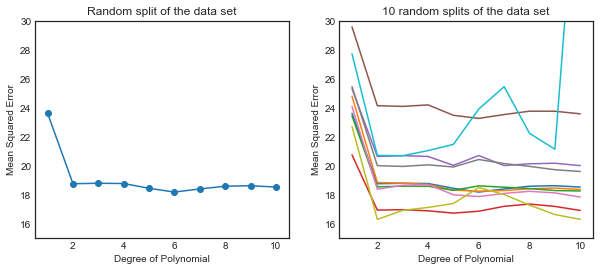

In [7]:
t_prop = 0.5
p_order = np.arange(1, 11)
r_state = np.arange(0, 10)

X, Y = np.meshgrid(p_order, r_state, indexing = "ij")
Z = np.zeros((p_order.size, r_state.size))

regr = skl_lm.LinearRegression()

# Generate 10 random splits of the dataset
for (i,j), v in np.ndenumerate(Z):
    poly = PolynomialFeatures(int(X[i,j]))
    X_poly = poly.fit_transform(df["horsepower"].values.reshape(-1, 1))
    
    X_train, X_test, y_train, y_test = train_test_split(X_poly, df["mpg"].ravel(), 
                                                        test_size = t_prop, random_state = Y[i, j])
    
    regr.fit(X_train, y_train)
    pred = regr.predict(X_test)
    Z[i, j] = mean_squared_error(y_test, pred)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))

#left plot (First split)
ax1.plot(X.T[0],Z.T[0], '-o')
ax1.set_title('Random split of the data set')

# Right plot (all splits)
ax2.plot(X,Z)
ax2.set_title('10 random splits of the data set')

for ax in fig.axes:
    ax.set_ylabel('Mean Squared Error')
    ax.set_ylim(15,30)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5,10.5)
    ax.set_xticks(range(2,11,2));

### Figure 5.4

In [8]:
p_order = np.arange(1,11)
r_state = np.arange(0,10)

# LeaveOneOut CV
regr = skl_lm.LinearRegression()
loo = LeaveOneOut()
loo.get_n_splits(df)
scores = list()

for i in p_order:
    poly = PolynomialFeatures(i)
    X_poly = poly.fit_transform(df.horsepower.values.reshape(-1,1))
    score = cross_val_score(regr, X_poly, df.mpg, cv=loo, scoring='neg_mean_squared_error').mean()
    scores.append(score)

In [9]:
# k-fold CV
folds = 10
elements = len(df.index)

X, Y = np.meshgrid(p_order, r_state, indexing='ij')
Z = np.zeros((p_order.size,r_state.size))

regr = skl_lm.LinearRegression()

for (i,j),v in np.ndenumerate(Z):
    poly = PolynomialFeatures(X[i,j])
    X_poly = poly.fit_transform(df.horsepower.values.reshape(-1,1))
    kf_10 = KFold(n_splits=folds, random_state=Y[i,j])
    Z[i,j] = cross_val_score(regr, X_poly, df.mpg, cv=kf_10, scoring='neg_mean_squared_error').mean()    

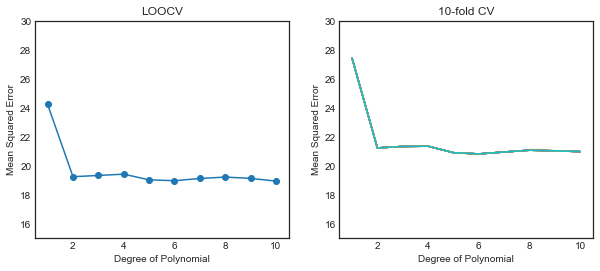

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

# Note: cross_val_score() method return negative values for the scores.
# https://github.com/scikit-learn/scikit-learn/issues/2439

# Left plot
ax1.plot(p_order, np.array(scores)*-1, '-o')
ax1.set_title('LOOCV')

# Right plot
ax2.plot(X,Z*-1)
ax2.set_title('10-fold CV')

for ax in fig.axes:
    ax.set_ylabel('Mean Squared Error')
    ax.set_ylim(15,30)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5,10.5)
    ax.set_xticks(range(2,11,2));